# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings(action="ignore")
pd.set_option("float_format", '{:.2f}'.format)

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


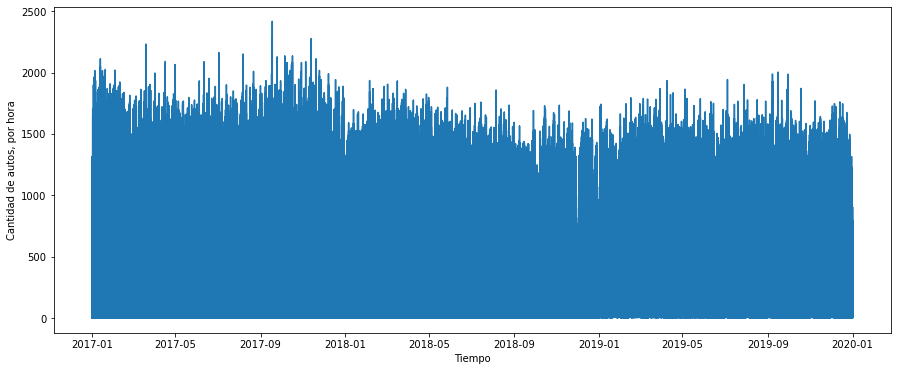

In [14]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [15]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


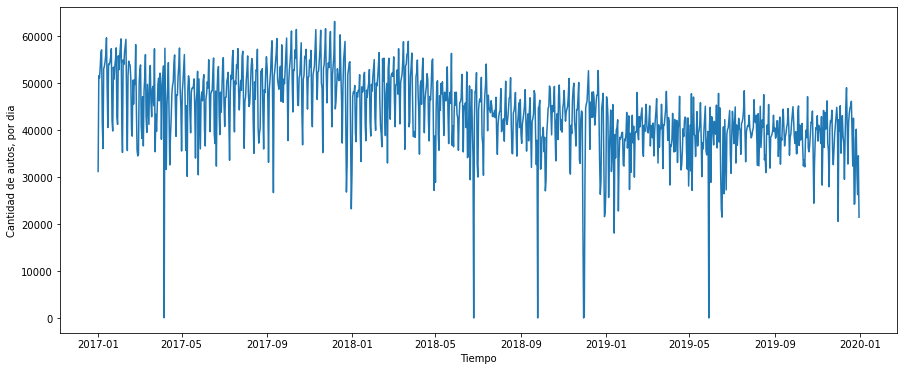

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

## PARTE A - Transformación de Datos

###  1. DETECCION Y ELIMINACION DE OUTLIERS

Según el gráfico anterior se observan que existen instancias con valores atípicos. 

Se tratan de días en los cuales circularon menos de 5000 vehículos y que en gran parte de esos días llegó a ser 0.

In [17]:
diario.cantidad_pasos[diario.cantidad_pasos<=5000]

fecha
2017-04-06     40
2018-06-25      0
2018-09-25      0
2018-11-30      0
2018-12-01    350
2019-05-29      0
Name: cantidad_pasos, dtype: int64

Sabiendo que estos atípicos alteran los resultados de los modelos de predicción a futuro, se procede a eliminarlos.

In [18]:
diario.cantidad_pasos[diario.cantidad_pasos <= 5000] = np.nan
diario.isna().sum()

cantidad_pasos    6
dtype: int64

In [19]:
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    0
dtype: int64


Una vez eliminados los valores atípicos, grafico nuevamente la serie de tiempo para ver como queda:

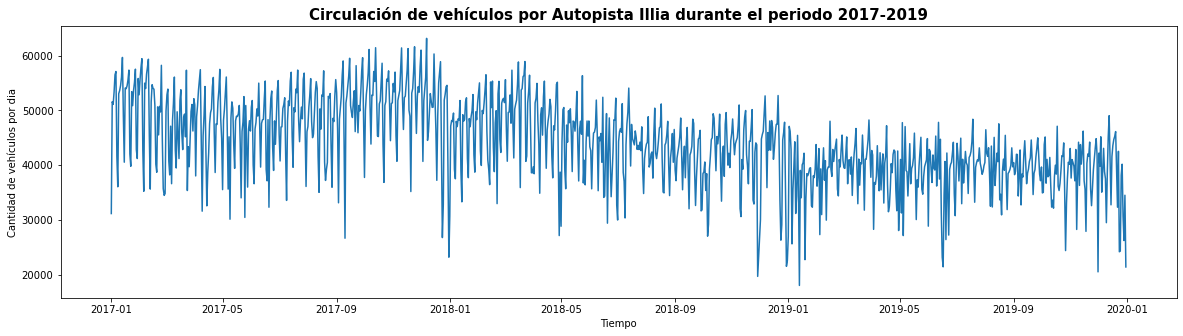

In [20]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por dia')
plt.title('Circulación de vehículos por Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

###  2. PREGUNTAS QUE SE PUEDEN RESPONDER CON EL DATASET

* ¿Cuántos vehículos salen los lunes hacia el centro?  
* ¿Cuándo se produjo la mayor cantidad de pasos por la Autopista Illia?

In [21]:
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


In [22]:
pregunta_1 = dataset[dataset.dia == 'Lunes']
pregunta_1 = pregunta_1[pregunta_1.sentido == 'Centro']
pregunta_1.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
231,Lunes,Centro,Pesado,2,2017-01-02
232,Lunes,Centro,Pesado,1,2017-01-02
233,Lunes,Centro,Pesado,3,2017-01-02
234,Lunes,Centro,Pesado,1,2017-01-02
235,Lunes,Centro,Pesado,18,2017-01-02


In [23]:
#Se ejecuta la siguiente línea para conocer el número máximo de pasos hacia sentido Centro un día Lunes
print('Número máximo de pasos en Centro es: ', pregunta_1.cantidad_pasos.max())

Número máximo de pasos en Centro es:  2134


In [24]:
#Se ejecuta la siguiente línea para conocer el total de pasos sentido Centro los días Lunes
print('Total de pasos en Centro los Lunes son:', pregunta_1.cantidad_pasos.sum())

Total de pasos en Centro los Lunes son: 3459619


In [25]:
#Para visualizar la/s fechas correspondientes a ese número máximo de pasos, realizo lo siguiente:
fecha_max = pregunta_1[pregunta_1.cantidad_pasos == 2134]
fecha_max

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
83380,Lunes,Centro,Liviano,2134,2017-10-16 20:00:00


Con este resultado, se define que el Lunes 16/10/2017 es el día Lunes que más vehículos se dirigieron en sentido Centro.

In [26]:
pregunta_2 = diario.cantidad_pasos[diario.cantidad_pasos==diario.cantidad_pasos.max()]
pregunta_2

fecha
2017-12-07   63127.00
Freq: D, Name: cantidad_pasos, dtype: float64

De acuerdo a lo que indica pregunta_2, se establece el 07/12/2017 como el día que se produjo la mayor cantidad de vehículos circulando por la Autopista Illia durante el periodo 2017-2019. 

Tal corroboración se verifica visualizando el gráfico anterior. **Cantidad total de vehículos: 63127.**

In [27]:
#Mediante la utilización de una máscara, se analiza en profundidad la totalidad de vehículos que circularon
mascara = (dataset['fecha'] >= '2017-12-07 00:00:00') & (dataset['fecha'] <= '2017-12-07 23:59:59')

In [28]:
dia_mayor = dataset.loc[mascara]
dia_mayor

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
97406,Jueves,Centro,Pesado,15,2017-12-07 00:00:00
97407,Jueves,Centro,Pesado,2,2017-12-07 00:00:00
97408,Jueves,Centro,Pesado,1,2017-12-07 00:00:00
97409,Jueves,Centro,Pesado,6,2017-12-07 00:00:00
97410,Jueves,Provincia,Pesado,12,2017-12-07 00:00:00
...,...,...,...,...,...
97702,Jueves,Centro,Liviano,957,2017-12-07 23:00:00
97703,Jueves,Centro,Pesado,18,2017-12-07 23:00:00
97704,Jueves,Provincia,Liviano,59,2017-12-07 23:00:00
97705,Jueves,Provincia,Liviano,981,2017-12-07 23:00:00


In [29]:
#Ejecutando la siguiente línea, debería llegar al resultado obtenido anteriormente con la totalidad de vehículos circulando
dia_mayor.cantidad_pasos.sum()

63127

###  3. RESAMPLEOS

In [30]:
semanal = dataset.resample('W', on = 'fecha').mean()

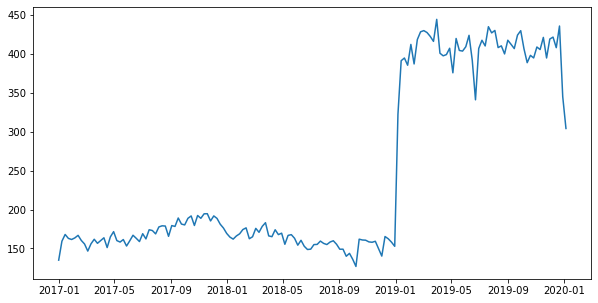

In [31]:
plt.figure(figsize=(10,5))
plt.plot(semanal.index,semanal.cantidad_pasos)
plt.show()

Se puede observar que realizar un resampleo semanal contiene demasiado ruido comparado con lo reflejado diariamente.

- Se propone visualizar un resampleo más a modo mensual

In [32]:
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


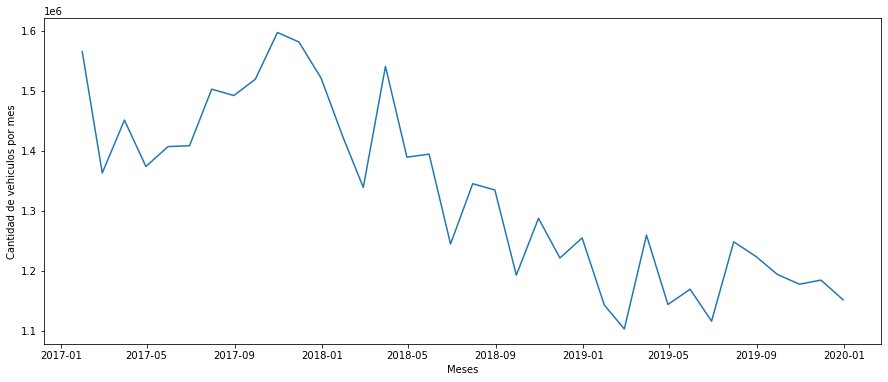

In [33]:
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Meses')
plt.ylabel('Cantidad de vehiculos por mes')
plt.show()

El gráfico con el resampleo a periocidad mensual no favorece ni ayuda ya que se establecen patrones definidos. Cada uno de los datos reflejarían mucho ruido para llevar a cabo un modelo.

**Decido usar la periocidad diaria, sabiendo que en pasos anteriores, procedí a no considerar los valores atipicos.** 

**La eliminación y polarización de outliers, me traería un mejor desempeño de modelos predictores en el tiempo.**

###  4. AUTOCORRELACION

Utilizando la media diaria, el modelo intepretaría mejor los datos, considerando además que los outliers fueron eliminados

In [34]:
nlags = 7*4
autocorr = acf(diario.cantidad_pasos, nlags = nlags)
autocorr.shape

(29,)

Procedo a graficar un correlograma para distintos valores de retardo k. Esto nos da la pauta de los valores de retardo para los cuales se tiene coeficiente de correlación válidos.

El mismo estará basado considerando el retardo de un año, es decir, 365 días.

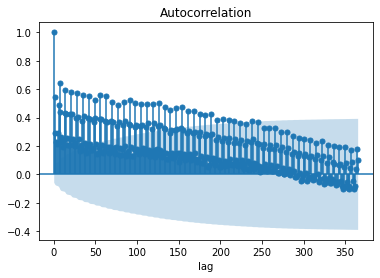

In [35]:
plot_acf(diario.cantidad_pasos, lags = 365)
plt.xlabel("lag")
plt.show()

Text(0.5, 0, 'lag')

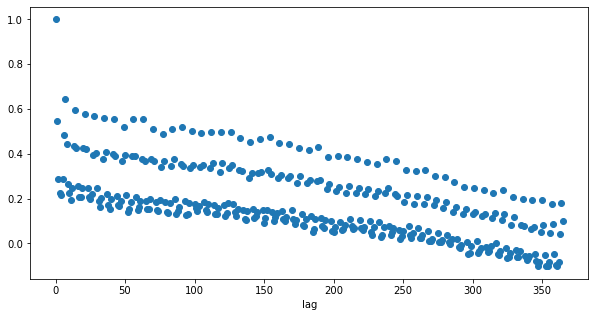

In [36]:
autocorr_año = acf(diario.cantidad_pasos, nlags = 365)
autocorr_año

plt.figure(figsize = (10,5))
plt.scatter(np.arange(365+1), autocorr_año)
plt.xlabel('lag')

Visualizando el retardo con el período de un año, grafico también considerando un retardo de 28 días (nlags).

Text(0.5, 0, 'lag')

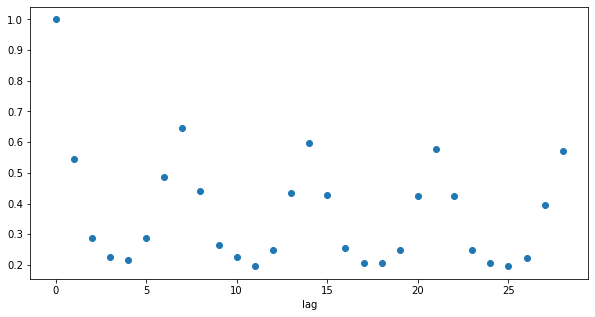

In [37]:
plt.figure(figsize = (10,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

Claramente la autocorrelación de la cantidad de pasos de vehículos es positiva, ya que hay una relación lineal positiva entre la variable cantidad_pasos y la misma variable un tiempo anterior. 

Se observa un patrón de comportamiento que indica que cada 7 días la autocorrelación se comporta de la misma manera. Por ejemplo la cantidad de vehículos que circulan un día determinado está muy relacionada con la cantidad de vehículos que circularon ese mismo día de la semana anterior. 

Se aprecia que la autocorrelación para un mismo día disminuye semana tras semana.

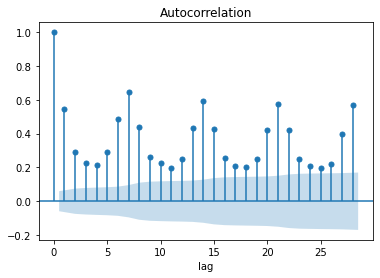

In [38]:
plot_acf(diario.cantidad_pasos, lags = nlags)
plt.xlabel("lag")
plt.show()

De acuerdo a lo indicado en el gráfico anterior, los coeficientes de autocorrealción son válidos, ya que se establecen los valores dentro del cono azul representando un intervalo de confianza del 95%. Todo resultado fuera de esa marca de agua, sugiere que probablemente sea una correlación y no una casualidad estadística.

###  5. COMPONENTES DE LA SERIE

#### 5.1 Tendencia y Media móvil

- Determino una ventana de fecha

In [39]:
ventana = int(365*1/7)

- Establezco una variable para que refleje el promedio de la tendencia

In [40]:
diario_mean_tend = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()

* Visualizo el gráfico con la media movil

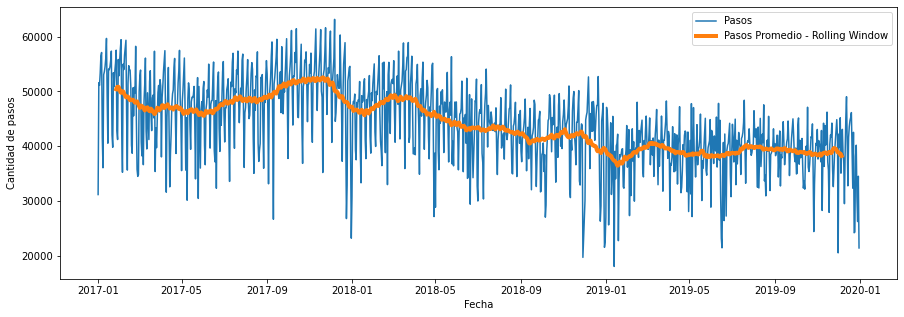

In [41]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Pasos')
plt.plot(diario_mean_tend, lw = 4, label = 'Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

Con la visualización de una media movil puedo determinar una tendencia. Claramente se observa que los pasos han disminuido con el correr de los años.

Para poder visualizar una línea de tendencia, procedo a establecer un modelo de regresión lineal.

In [42]:
diario['fecha_numeros']= diario.index.map(datetime.datetime.toordinal)

In [43]:
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

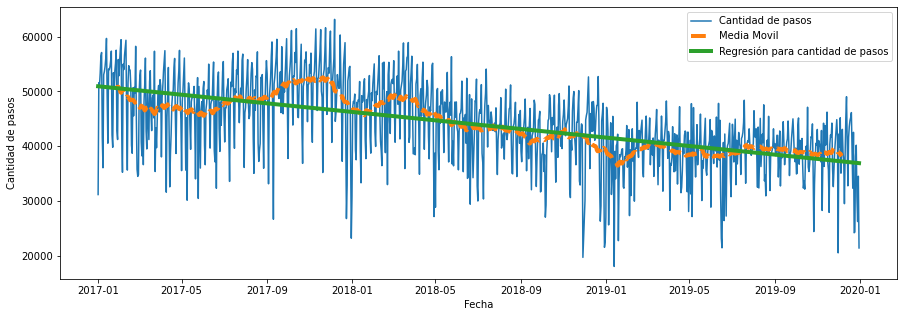

In [44]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos,label = 'Cantidad de pasos')
plt.plot(diario_mean_tend, ls = '--', lw = 4, label = 'Media Movil')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

Estableciendo la línea de tendencia, se corrobora datos con una pendiente negativa con el correr del tiempo.

* Visualización de componente estacional + ruido blanco junto con la media movil

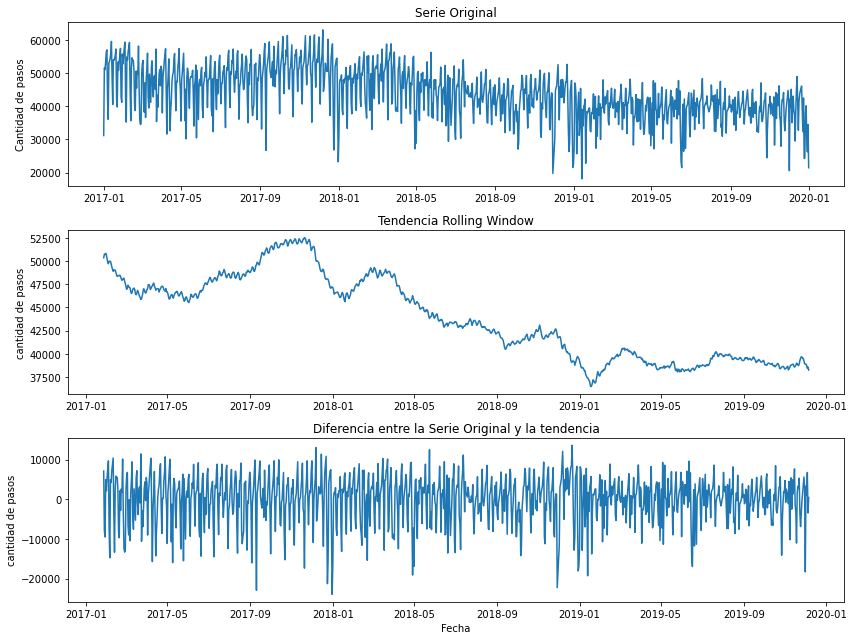

In [45]:
plt.figure(figsize = (12,9))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(diario_mean_tend)
plt.ylabel('cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la Serie Original y la tendencia')
plt.plot(diario.index, diario.cantidad_pasos - diario_mean_tend)
plt.xlabel('Fecha')
plt.ylabel('cantidad de pasos')

plt.tight_layout()
plt.show()

**Toda Serie de Tiempo está compuesta de una tendencia, estacionalidad y ruido blanco.** 

**La diferencia entre esta tendencia y la Serie Orignial nos da el ruido que suelen tener cada Serie de Tiempo.**

#### 5.2 Descomposición estacional

* Descomposición utilizando medias moviles

In [46]:
resultado = seasonal_decompose(diario.cantidad_pasos, model='additive')

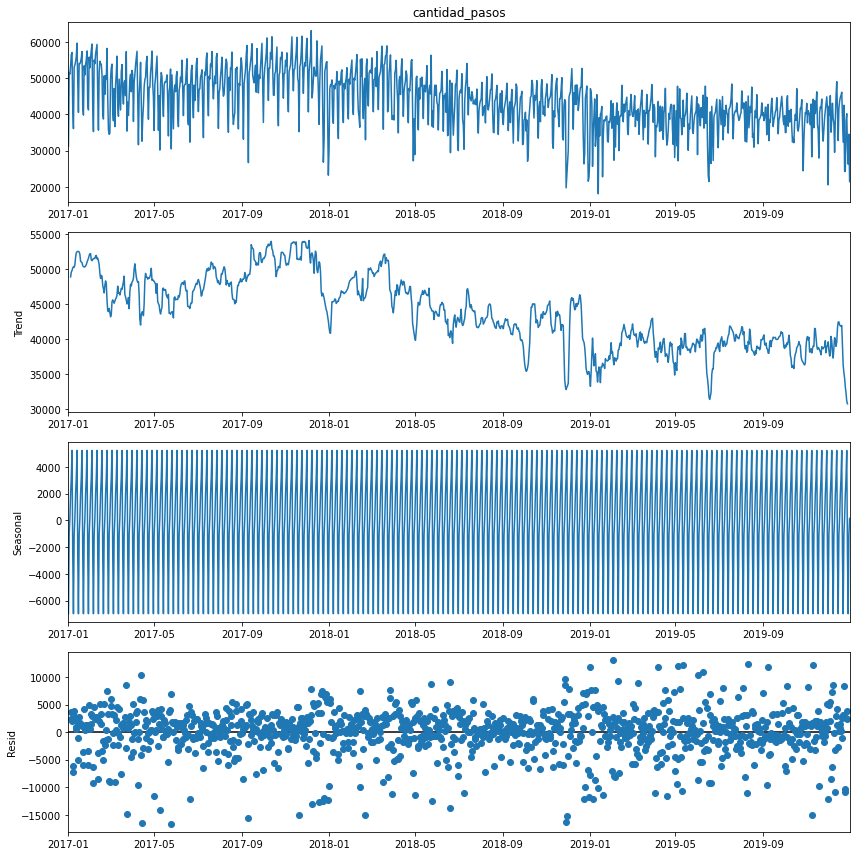

In [47]:
plt.rcParams['figure.figsize'] = [12,12]
resultado.plot()
plt.show()

Utilizando la descomposición de medias moviles puedo observar:  

1 - La tendencia que tienen los datos a lo largo del tiempo, en este caso volatil y con tendencia negativa.

2 - La estacionalidad, con la que se construirá luego un modelo Sarima, ya que aprende de la estacionalidad que tengan los datos en el tiempo.

3 - Los residuos que oxilan en 0, lo cual es buen aporte al modelo Sarima.

Para este último punto, los residuos se pueden analizar a través de un histograma. 

**Se debe corroborar que los residuos posean una distribución normal para considerar una buena estimación.**

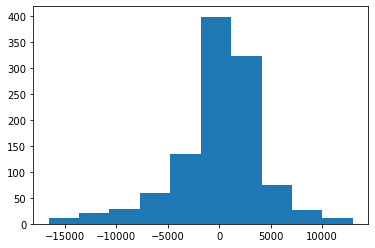

In [48]:
plt.figure(figsize = (6,4))
plt.hist(resultado.resid)
plt.show()

Una manera de seleccionar cuál es la descomposición correcta es usando un enfoque gráfico. 

En un modelo aditivo, la magnitud de la estacionalidad no cambia en relación al tiempo, es decir, el modelo aditivo no varía en frecuencia y amplitud con el tiempo. 

La estacionalidad es independiente de la variación de la tendencia. 

#### 5.3 Tendencia Negativa: Migración a otras formas de pago.

* Mediante un gráfico visualizo la cantidad de flujo vehicular con su correspondiente forma de pago elegida, comparando aquellos usuarios con opción pago Efectivo contra aquellos que optan por Telepase.

In [49]:
#Uno los 3 datasets
dataset_3 = pd.concat([data_2019, data_2018, data_2017])

#Elijo solamente estación Illia y forma de pago Efectivo
mask_t = np.logical_and(dataset_3.estacion=='Illia', dataset_3.forma_pago == 'TELEPASE')
dataset_3 = dataset_3[mask_t]
#Elimino las columnas que no voy a utilizar
dataset_3.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Convierto la columna fecha a formato datetime, y le uno la hora_fin como hora
dataset_3['fecha2'] = pd.to_datetime(dataset_3.fecha) + pd.to_timedelta(dataset_3.hora_fin, unit = 'h')
#Elimino las columnas fecha y hora_fin ya que las inclui en el campo fecha2
dataset_3.drop(columns=['fecha','hora_fin'], inplace = True)
#Procedo a corregir el nombre de fecha2 a fecha
dataset_3.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordeno el dataset_3 por fecha
dataset_3.sort_values('fecha', inplace = True)
dataset_3.reset_index(drop=True, inplace = True)
#Resamplo los datos para agrupar por dia, y asi obtener una visualización mas concreta
diario_t = dataset_3.resample('D', on = 'fecha').sum()

* Resampleo mensual

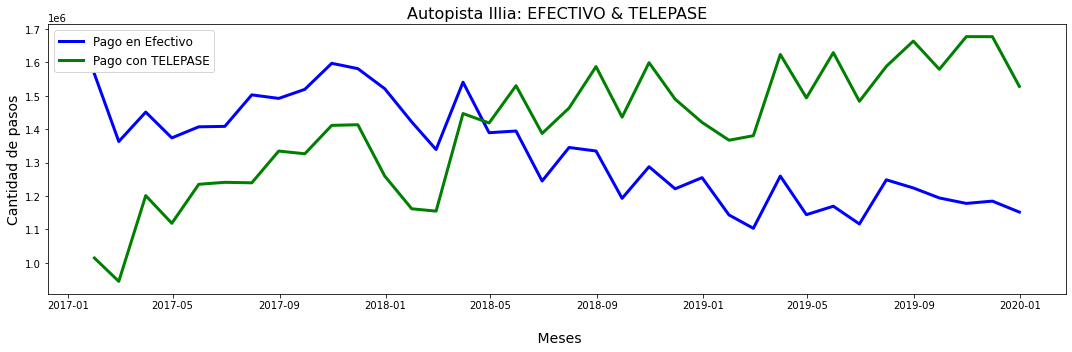

In [50]:
mensual_t = dataset_3.resample('M', on = 'fecha').sum()
mensual = dataset.resample('M', on = 'fecha').sum()

plt.figure(figsize=(15,5))
plt.plot(mensual.index, mensual.cantidad_pasos,lw=3,color='blue', label='Pago en Efectivo')
plt.plot(mensual_t.index, mensual_t.cantidad_pasos, lw=3, color='green',label='Pago con TELEPASE')
plt.title ('Autopista Illia: EFECTIVO & TELEPASE', color='black', fontsize=16)
plt.xlabel('\n Meses', color='black',fontsize=14)
plt.ylabel('Cantidad de pasos', color='black',fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Se puede observar que hasta el mes de Marzo - Abril del año 2018, la forma de pago elegida por los usuarios era en efectivo. 

Mientras que a partir de Mayo del año 2018, los usuarios optaron por la forma de pago utilizando Telepase en su mayoría.

#### 5.4 Serie con valores atípicos

Si bien, estos valores fueron tratados en la Parte "A", en Tratamiento de Outliers, sobre el primer semestre del 2019, se pudo observar lo siguiente:

*  2019-05-29: [Paro general de la CGT contra el Gobierno de Macri](https://www.perfil.com/noticias/politica/como-se-vive-paro-miercoles-29-de-mayo-en-las-redes-sociales.phtml)

Se toma la decision de reemplazar eso valores atípicos mediante la interpolacion. La interpolación es el proceso de encontrar un valor entre dos puntos en una línea o una curva.

La interpolación no solo es útil en estadística, sino que también es útil en ciencia, negocios o cuando existe la necesidad de predecir valores que se encuentran dentro de dos puntos de datos existentes.

## PARTE B - Modelo de Machine Learning

### PREDICCION A FUTURO

#### Transformaciones de datos y métrica elegida para evaluar resultados

Para llevar a cabo este punto, utilizo el dataset resultante del análisis exploratorio de datos del punto anterior del proyecto.

In [51]:
diario = diario.drop(columns = "fecha_numeros")
diario

,cantidad_pasos
fecha,
2017-01-01,31183.00
2017-01-02,51568.00
2017-01-03,51093.00
2017-01-04,53332.00
2017-01-05,56486.00
...,...
2019-12-27,40182.00
2019-12-28,30681.00
2019-12-29,26259.00


* La métrica que voy a utilizar es la raíz del error cuadrático medio (RMSE) para evaluar los distintos modelos. (Ya importada al principio del proyecto)

#### - Modelo Benchmark

Procedo a utilizar el tercer y cuarto trimestre del año 2019. Considerando que la serie es estacionaria, seguramente su comportamiento sea repetitivo con el paso de los meses.

* Análisis del tercer trimestre del año 2019

In [52]:
lim_x1 = "2019-07-01"
lim_x2 = "2019-09-30"
X_bench = diario[(diario.index >= lim_x1)&(diario.index <= lim_x2)]

* Análisis del cuarto trimestre del año 2019

In [53]:
lim_y1 = "2019-10-01"
lim_y2 = "2019-12-31"
y_bench = diario[(diario.index >= lim_y1)&(diario.index <= lim_y2)]

* Establezco la variable y_bench como función de cálculos para la ventana móvil.

In [54]:
y_benchm = X_bench.cantidad_pasos.rolling(window = 1, center = False).mean()

* Grafico lo obtenido para comparar

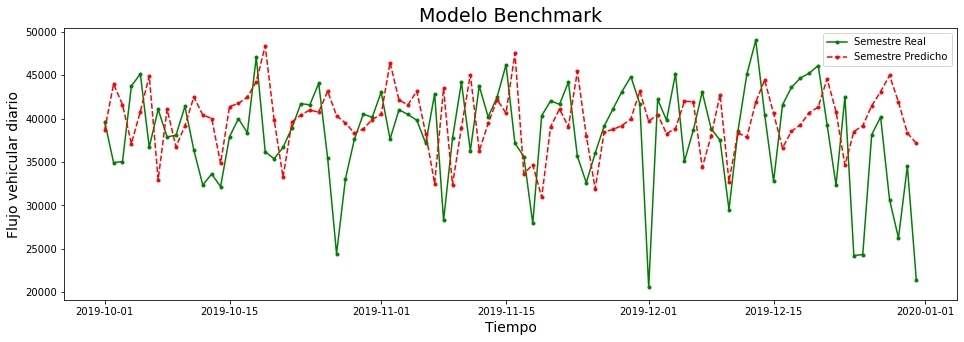

In [55]:
plt.figure (figsize=(16,5))
plt.plot(y_bench.index,y_bench, marker = ".", color = "green", label = "Semestre Real")
plt.plot(y_bench.index, y_benchm,  marker = ".", color = "red", label = "Semestre Predicho", ls =  "--")
plt.title("Modelo Benchmark", size = 19)
plt.xlabel("Tiempo", size = 14)
plt.ylabel("Flujo vehicular diario", size = 14)
plt.legend()
plt.show()

* Cálculo del RMSE

In [56]:
benchmark_rmse=np.sqrt(mean_squared_error(y_bench, y_benchm))
print(f'RMSE en Benchmark: {benchmark_rmse}')

RMSE en Benchmark: 6928.222581680265


El trimestre predicho es bastante diferente al real. 

En cuanto al error era de esperarse que fuera alto.

Se predice un aumento en el flujo vehicular para el 2020, pero en realidad la tendencia es hacia abajo. Podemos decir que el modelo benchmark se ve afectado debido que al realizar el resampleo de los datos, los mismos son cortados para el período seleccionado de fines del año 2019.

#### - Metodología Prophet

Utilizar este procedimiento, me va a ayudar para pronosticar datos de series de tiempo basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria. 

Prophet funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. 

Una de sus características de este modelo es que es robusto ante los datos faltantes y los cambios en la tendencia, y normalmente maneja bien los valores atípicos.

In [57]:
! pip install fbprophet

In [58]:
from scipy.stats import boxcox
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [59]:
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183.00
2017-01-02,51568.00
2017-01-03,51093.00
2017-01-04,53332.00
2017-01-05,56486.00


* Realizo una copia del dataset original para poder trabajarlo con Prophet

In [60]:
diario_ph = diario.copy()

In [61]:
diario_ph["ds"] = diario.index
diario_ph["y"] = diario.cantidad_pasos

diario_ph.drop(["cantidad_pasos"],axis=1, inplace=True)

diario_ph.reset_index(drop=True, inplace=True)
diario_ph

,ds,y
0,2017-01-01,31183.00
1,2017-01-02,51568.00
2,2017-01-03,51093.00
3,2017-01-04,53332.00
4,2017-01-05,56486.00
...,...,...
1090,2019-12-27,40182.00
1091,2019-12-28,30681.00
1092,2019-12-29,26259.00
1093,2019-12-30,34523.00


* Localizo una ubicación precisa para poder separar los datos en train y test.

In [62]:
diario_ph.loc[912]

ds    2019-07-02 00:00:00
y                 43996.0
Name: 912, dtype: object

In [63]:
train_ph = diario_ph.loc[:912,:]
test_ph = diario_ph.loc[913:,:]

In [64]:
train_ph

,ds,y
0,2017-01-01,31183.00
1,2017-01-02,51568.00
2,2017-01-03,51093.00
3,2017-01-04,53332.00
4,2017-01-05,56486.00
...,...,...
908,2019-06-28,44179.00
909,2019-06-29,34754.00
910,2019-06-30,30793.00
911,2019-07-01,38705.00


In [65]:
test_ph

,ds,y
913,2019-07-03,41613.00
914,2019-07-04,37124.00
915,2019-07-05,40815.00
916,2019-07-06,44932.00
917,2019-07-07,32975.00
...,...,...
1090,2019-12-27,40182.00
1091,2019-12-28,30681.00
1092,2019-12-29,26259.00
1093,2019-12-30,34523.00


In [66]:
prophet = Prophet()
prophet.fit(train_ph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
y_train_pred_ph = prophet.predict(train_ph)
y_test_pred_ph = prophet.predict(test_ph)

In [68]:
data_frame_futuro = prophet.make_future_dataframe(periods=365)
forecast = prophet.predict(data_frame_futuro)

In [69]:
data_frame_futuro

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
1273,2020-06-27
1274,2020-06-28
1275,2020-06-29
1276,2020-06-30


In [70]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,49127.48,33140.26,44616.33,49127.48,49127.48,-10454.85,-10454.85,-10454.85,-7723.91,-7723.91,-7723.91,-2730.94,-2730.94,-2730.94,0.00,0.00,0.00,38672.63
1,2017-01-02,49126.29,39279.59,51219.85,49126.29,49126.29,-3837.14,-3837.14,-3837.14,-980.84,-980.84,-980.84,-2856.30,-2856.30,-2856.30,0.00,0.00,0.00,45289.15
2,2017-01-03,49125.10,40628.45,52376.68,49125.10,49125.10,-2611.28,-2611.28,-2611.28,333.89,333.89,333.89,-2945.17,-2945.17,-2945.17,0.00,0.00,0.00,46513.82
3,2017-01-04,49123.91,42178.48,54126.94,49123.91,49123.91,-728.91,-728.91,-728.91,2268.63,2268.63,2268.63,-2997.54,-2997.54,-2997.54,0.00,0.00,0.00,48395.00
4,2017-01-05,49122.72,43745.87,55799.75,49122.72,49122.72,454.18,454.18,454.18,3468.16,3468.16,3468.16,-3013.98,-3013.98,-3013.98,0.00,0.00,0.00,49576.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2020-06-27,39185.26,27497.75,40168.11,36388.64,41707.75,-5312.47,-5312.47,-5312.47,-2932.53,-2932.53,-2932.53,-2379.94,-2379.94,-2379.94,0.00,0.00,0.00,33872.79
1274,2020-06-28,39184.55,23090.88,35434.26,36373.34,41716.25,-9940.99,-9940.99,-9940.99,-7723.91,-7723.91,-7723.91,-2217.09,-2217.09,-2217.09,0.00,0.00,0.00,29243.56
1275,2020-06-29,39183.85,29165.52,42868.73,36357.38,41724.33,-3017.85,-3017.85,-3017.85,-980.84,-980.84,-980.84,-2037.00,-2037.00,-2037.00,0.00,0.00,0.00,36166.00
1276,2020-06-30,39183.14,31386.45,44042.44,36339.67,41725.07,-1508.23,-1508.23,-1508.23,333.89,333.89,333.89,-1842.12,-1842.12,-1842.12,0.00,0.00,0.00,37674.91


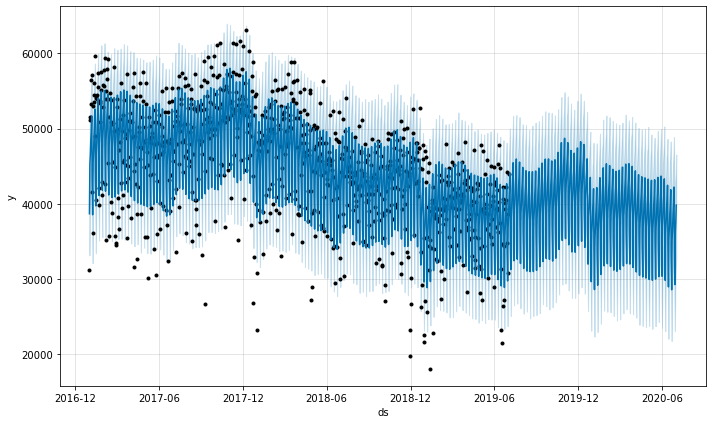

In [71]:
fig1 = prophet.plot(forecast)

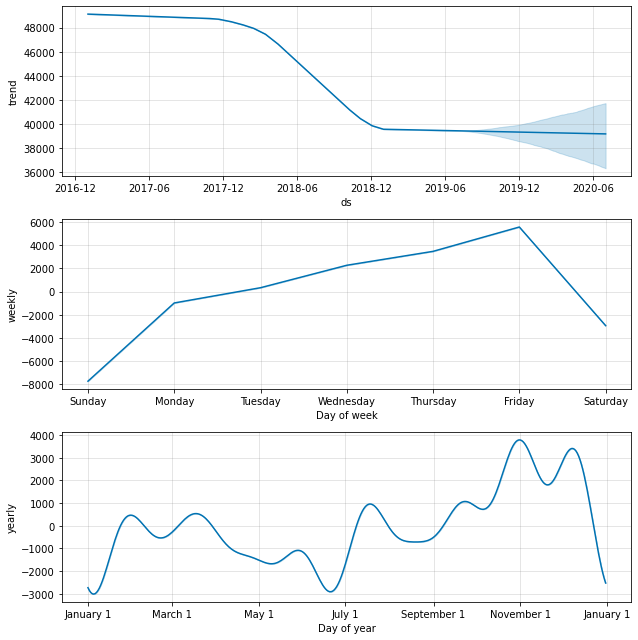

In [72]:
fig1 = prophet.plot_components(forecast)

In [73]:
y_train_ph = train_ph["y"]
y_test_ph = test_ph["y"]

In [74]:
RMSE_train_ph = mean_squared_error(y_train_ph, y_train_pred_ph["yhat"])
print('RMSE EN TRAIN, PROPHET:',round(np.sqrt(RMSE_train_ph),2))

RMSE_test_ph = mean_squared_error(y_test_ph, y_test_pred_ph["yhat"])
print('RMSE EN TEST, PROPHET:',round(np.sqrt(RMSE_test_ph),2))

RMSE EN TRAIN, PROPHET: 4731.11
RMSE EN TEST, PROPHET: 5154.7


#### - RANDOM FOREST REGRESSOR

Modelo para predecir el último trimestre del 2019 dividiendo el dataset en train y test. Se analiza estación Illia, para pago en efectivo.

* Primero, se define cantidad de días que se van a tomar para predecir el valor siguiente.

In [75]:
look_back = 90 # 90 días. 1 Trimestre en días.

# Creo las 'X' e 'y' con ceros para luego llenar con los datos.  
T = diario.cantidad_pasos.shape[0]
T

X = np.zeros((T - look_back - 1,look_back))
y = np.zeros(T - look_back - 1)
print(X.shape, y.shape)

(1004, 90) (1004,)


* Lleno las 'X' y las 'y'

In [76]:
for i in range(X.shape[0]):
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

In [77]:
print(X)

[[31183. 51568. 51093. ... 51074. 46235. 52127.]
 [51568. 51093. 53332. ... 46235. 52127. 50995.]
 [51093. 53332. 56486. ... 52127. 50995. 38045.]
 ...
 [38348. 37170. 39669. ... 24349. 38168. 40182.]
 [37170. 39669. 34943. ... 38168. 40182. 30681.]
 [39669. 34943. 35054. ... 40182. 30681. 26259.]]


In [78]:
print(y)

[50995. 38045. 48833. ... 30681. 26259. 34523.]


**Train Test Split**

Train = 2 años y medio más antiguos, es decir 913 días. 

Test = Medio año reciente, es decir 182 días.

In [79]:
rf_train = 913 - look_back # Instancias Train
rf_test = 182 # Instancias Test
rf_total = rf_train + rf_test
print(f'rf_total: {rf_total}')

length_total = rf_train + rf_test + look_back
print(f'length_total: {length_total}')

X_train = X[:rf_train,:]
y_train = y[:rf_train]
print(X_train.shape, y_train.shape)

X_test = X[rf_train:rf_train+rf_test,:]
y_test = y[rf_train:rf_train+rf_test]
print(X_test.shape, y_test.shape)

rf_total: 1005
length_total: 1095
(823, 90) (823,)
(181, 90) (181,)


In [80]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

In [81]:
y_pred_rf = rf.predict(X)
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [82]:
y_test_pred_rf.shape

(181,)

In [83]:
y_train_pred_rf.shape

(823,)

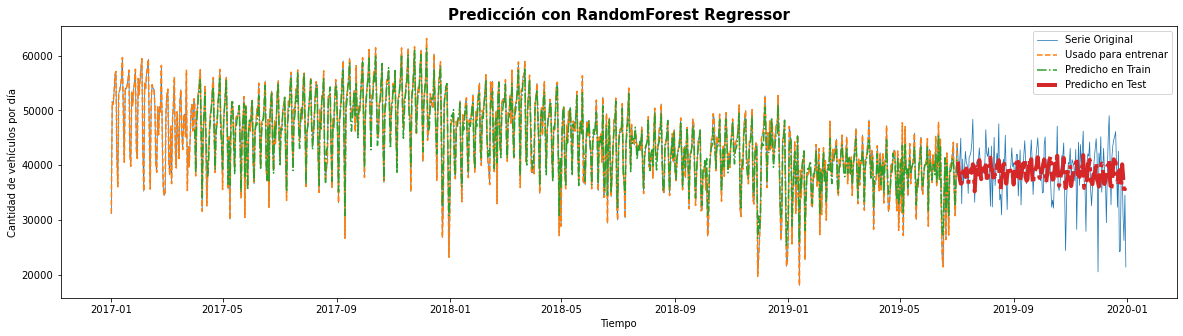

In [84]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:rf_train + look_back], diario[:rf_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + rf_train], y_train_pred_rf,'-.',label = 'Predicho en Train')
plt.plot(diario.index[rf_train+look_back: length_total-1], y_test_pred_rf,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest Regressor", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [85]:
rmse_train_rf =  np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
print(f'RMSE EN TRAIN: {round(rmse_train_rf,2)}')

RMSE EN TRAIN: 1814.24


In [86]:
rmse_test_rf =  np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(f'RMSE EN TEST: {round(rmse_test_rf,2)}')

RMSE EN TEST: 4219.53


#### - XGBOOST

In [87]:
xgb= XGBRegressor(objective = 'reg:squarederror',random_state=42)

In [88]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
y_train_pred_xg = xgb.predict(X_train)
y_test_pred_xg = xgb.predict(X_test)

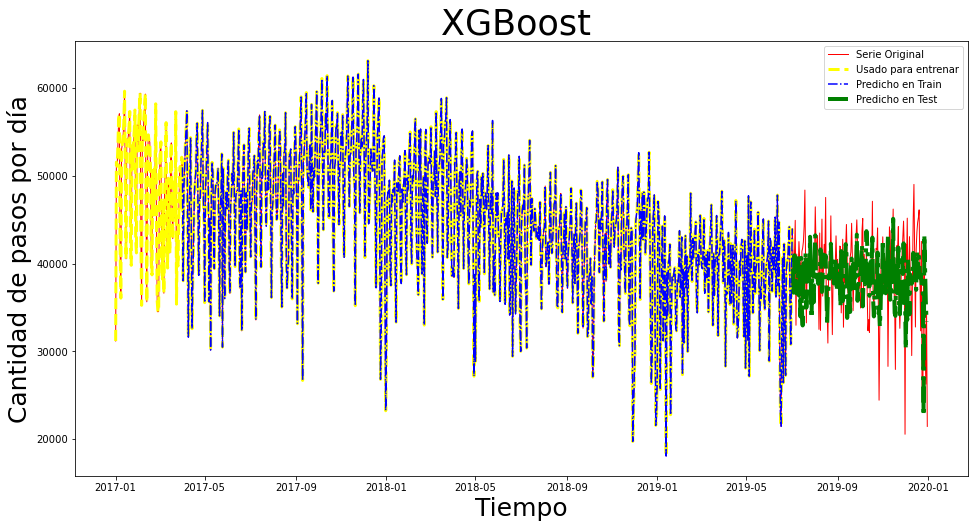

In [90]:
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(diario.index[:rf_train + look_back], diario[:rf_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + rf_train], y_train_pred_xg,'-.',color='blue',label = 'Predicho en Train')
plt.plot(diario.index[rf_train+look_back: length_total-1], y_test_pred_xg,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.title('XGBoost ', size= 35)
plt.xlabel('Tiempo', size= 25)
plt.ylabel('Cantidad de pasos por día', size= 25)
plt.legend()
plt.show()

In [91]:
print("RMSE Entrenamiento: ", np.sqrt(mean_squared_error(y_train, y_train_pred_xg)))
print("RMSE Test: ", np.sqrt(mean_squared_error(y_test, y_test_pred_xg)))

RMSE Entrenamiento:  11.996805772309983
RMSE Test:  4827.730609156481


- DE LOS MODELOS UTILIZADOS ELIJO **UTILIZAR EL METODO RANDOM FOREST REGRESSOR**.

#### - OPTIMIZACIÓN DE HIPERPARAMETROS

* Determino utilizar RandomSearchCV como método de optimización de hiperparámetros.

In [92]:
param_grid = {'n_estimators': [500, 600, 700, 800, 1000],
              'max_features':['auto', 'sqrt'],
              'max_depth': [None, 1, 2, 3, 5, 10, 100],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf':[1, 2, 3, 4],
              'bootstrap':[True, False]}

tss_cv = TimeSeriesSplit(n_splits=10)

rf_cv = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid,
                           cv=tss_cv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')

In [93]:
%%time
rf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Wall time: 3min 9s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 1, 2, 3, 5, 10,
                                                      100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [500, 600, 700, 800,
                                                         1000]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [94]:
rf_cv.best_score_

-5078.864256533583

In [95]:
rf_cv.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [96]:
print(rf_cv.best_estimator_)

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=3, n_estimators=800, random_state=42)


In [97]:
y_train_pred_rf_cv = rf_cv.predict(X_train)
y_test_pred_rf_cv = rf_cv.predict(X_test)

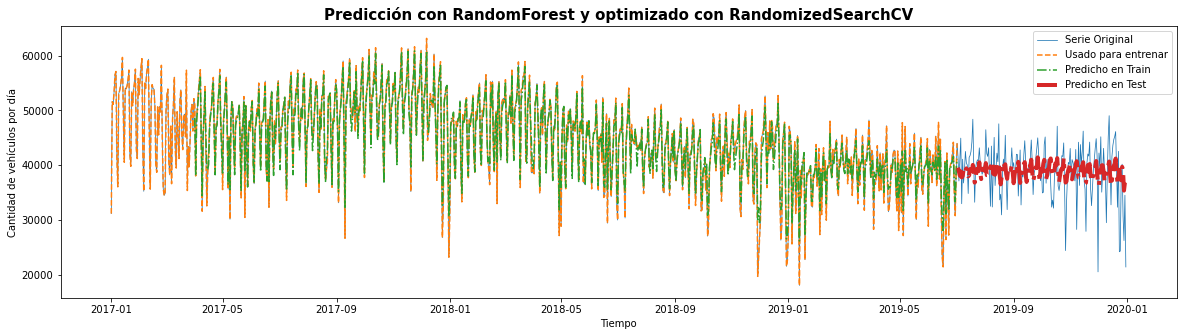

In [98]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:rf_train + look_back], diario[:rf_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + rf_train], y_train_pred_rf_cv,'-.',label = 'Predicho en Train')
plt.plot(diario.index[rf_train+look_back: length_total-1], y_test_pred_rf_cv,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest y optimizado con RandomizedSearchCV", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [99]:
rmse_train_rf_cv = np.sqrt(mean_squared_error(y_train, y_train_pred_rf_cv))
print(f'RMSE EN TRAIN, MODELO RANDOM FOREST OPTIMIZADO: {round(rmse_train_rf_cv,2)}')

RMSE EN TRAIN, MODELO RANDOM FOREST OPTIMIZADO: 1759.59


In [100]:
rmse_test_rf_cv = np.sqrt(mean_squared_error(y_test, y_test_pred_rf_cv))
print(f'RMSE EN TEST, MODELO RANDOM FOREST OPTIMIZADO: {round(rmse_test_rf_cv,2)}')

RMSE EN TEST, MODELO RANDOM FOREST OPTIMIZADO: 4227.72


**Al comparar el modelo RandomForest Regressor optimizado con el modelo Benchmark podemos observar que la mejora es grande.** 

RMSE DE MODELO BENCHMARK = 6928 

**RMSE DE MODELO RANDOM FOREST OPTIMIZADO = 4231**

#### - INFORMACION UTILIZADA POR EL MODELO PARA PREDECIR

El modelo está utilizando 90 días de look back para predecir el valor siguiente a través del método de regresión que plantea el modelo Random Forest. 

Para llevarlo a cabo se divide el dataset en 10 segmentos. Utiliza el primer segmento para entrenar el modelo con los hiperparámetros optimizados con RandomSearchCV, y el segundo segmento para testearlo. Luego, usa los 2 primeros segmentos para entrenar el modelo de la misma forma y usa el tercer segmento para testear. Se repiten los ciclos de manera sucesiva hasta utilizar los 10 segmentos.

#### MODELO SARIMAX - MODELO PRONOSTICO DE VALORES FUTUROS PARA SERIES DE TIEMPO

Este modelo está basado en ARIMA que significa AutoRegressive Integrated Moving Average.

El modelo ARIMA está compuesto por 3 parámetros que tienen en cuenta la estacionalidad, la tendencia y el ruido en los conjuntos de datos. Estos son 3 números enteros distintos: p, d y q. Los modelos ARIMA se denotan con la notación ARIMA (p, d, q).

* "p" es la parte auto-regresiva del modelo. Nos permite incorporar el efecto de valores pasados.

* "d" es la parte integrada del modelo. Esto incluye términos en el modelo que incorporan la cantidad de diferenciación (es decir, el número de puntos de tiempo pasado para restar del valor actual) para aplicar a la serie de tiempo.

* "q" es la parte media móvil del modelo. Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.

Para este ejercicio se consideran los siguientes parámetros:

* "p" = 7, ya que los datos toman en cuenta lo que sucede 7 días antes de la fecha del valor observado.

* "d" = 1. Se toma este valor como grado de diferenciación.

* "q" = 7. Se adopta el mismo valor que p.

In [101]:
sarimax_model = sm.tsa.statespace.SARIMAX(diario.cantidad_pasos,
                                order=(7, 1, 7),
                                seasonal_order=(7, 1, 7, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [102]:
resultado_sarimax = sarimax_model.fit()

In [103]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 12)   Log Likelihood               -9927.528
Date:                            Sun, 19 Sep 2021   AIC                          19913.057
Time:                                    19:56:36   BIC                          20055.090
Sample:                                01-01-2017   HQIC                         19967.066
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6431      0.582     -1.105      0.269      -1.784       0.498
ar.L2         -0.7724      0.165     -4.690      0.000      -1.095      -0.450
ar.L3         -0.7265      0.484     -1.502      0.133      -1.675       0.222
ar.L4         -0.6741      0.321     -2.100      0.036      -1.303      -0.045
ar.L5         -0.8094      0.273     -2.962      0.003      -1.345      -0.274
ar.L6         -0.6197      0.501     -1.237      0.216      -1.601       0.362
ar.L7          0.1596      0.110      1.453      0.146      -0.056       0.375
ma.L1         -0.1163      0.582     -0.200      0.842      -1.257       1.024
ma.L2          0.1392      0.535      0.260      0.795      -0.909       1.187
ma.L3          0.0364      0.497      0.073      0.942      -0.937       1.010
ma.L4         -0.0521      0.400     -0.130      0.896      -0.837       0.732
ma.L5          0.2229      0.397      0.561      0.574      -0.555       1.001
ma.L6         -0.0951      0.474     -0.201      0.841      -1.024       0.834
ma.L7         -0.7128      0.488     -1.462      0.144      -1.669       0.243
ar.S.L12      -1.0136      0.546     -1.856      0.063      -2.084       0.057
ar.S.L24      -0.8876      0.578     -1.536      0.124      -2.020       0.245
ar.S.L36      -0.8217      0.578     -1.421      0.155      -1.955       0.312
ar.S.L48      -0.5845      0.500     -1.170      0.242      -1.564       0.395
ar.S.L60      -0.5929      0.443     -1.340      0.180      -1.460       0.275
ar.S.L72      -0.5946      0.313     -1.897      0.058      -1.209       0.020
ar.S.L84      -0.0925      0.099     -0.933      0.351      -0.287       0.102
ma.S.L12       0.0675      0.538      0.125      0.900      -0.988       1.123
ma.S.L24      -0.0259      0.428     -0.061      0.952      -0.864       0.813
ma.S.L36      -0.0490      0.359     -0.136      0.891      -0.752       0.654
ma.S.L48      -0.2418      0.469     -0.515      0.606      -1.161       0.678
ma.S.L60       0.0795      0.334      0.238      0.812      -0.575       0.734
ma.S.L72       0.0498      0.330      0.151      0.880      -0.598       0.697
ma.S.L84      -0.4014      0.330     -1.215      0.224      -1.049       0.246
sigma2       5.31e+07      1e-08   5.28e+15      0.000    5.31e+07    5.31e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):               808.44
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -1.34
Prob(H) (two-sided):                  0.42   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] 

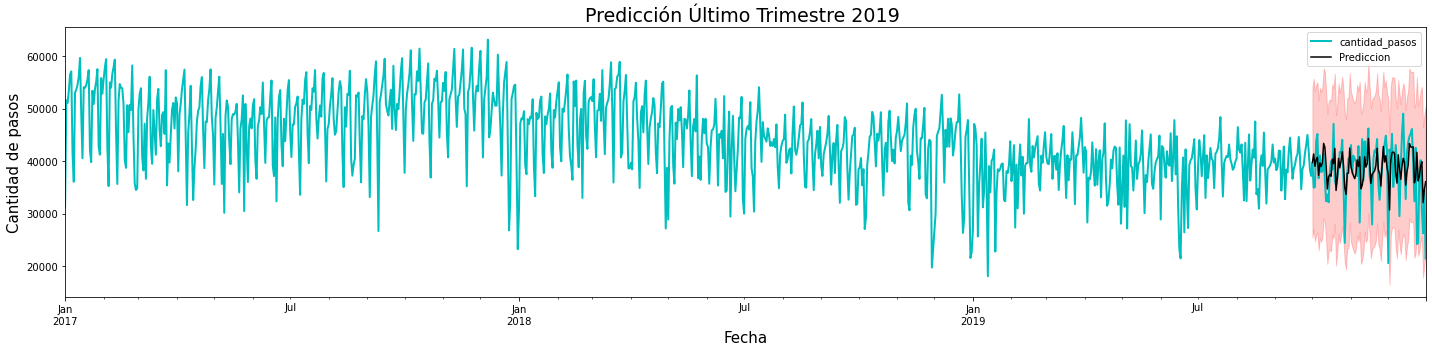

In [104]:
pred = resultado_sarimax.get_prediction(start=datetime.datetime(2019,10,1), dynamic=False)
c_pred = pred.conf_int()
ax = diario['2017':].plot(label='Serie Original',color='c',lw = 2,figsize=(20,5))

pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=1, color='Black')

ax.fill_between(c_pred.index,
                c_pred.iloc[:, 0],
                c_pred.iloc[:, 1], color='red', alpha=0.2)
plt.title("Predicción Último Trimestre 2019 ", fontsize=19)
plt.xlabel('Fecha',size=15)
plt.ylabel('Cantidad de pasos', size=15)
plt.legend()
plt.tight_layout()
plt.show()

In [105]:
y_forecasted = pred.predicted_mean
y_truth = diario['2019-10-01':]

print(f'AIC PARA MODELO SARIMAX: {round(resultado_sarimax.aic,2)}')
rmse_pred =  np.sqrt(mean_squared_error(y_truth, y_forecasted))
print(f'RMSE EN TEST, MODELO SARIMAX.: {round(rmse_pred,2)}')

AIC PARA MODELO SARIMAX: 19913.06
RMSE EN TEST, MODELO SARIMAX.: 5362.78


#### - APLICACIÓN Y COMPORTAMIENTO DEL MODELO PARA PREDECIR EL TRAFICO DURANTE EL AÑO 2020

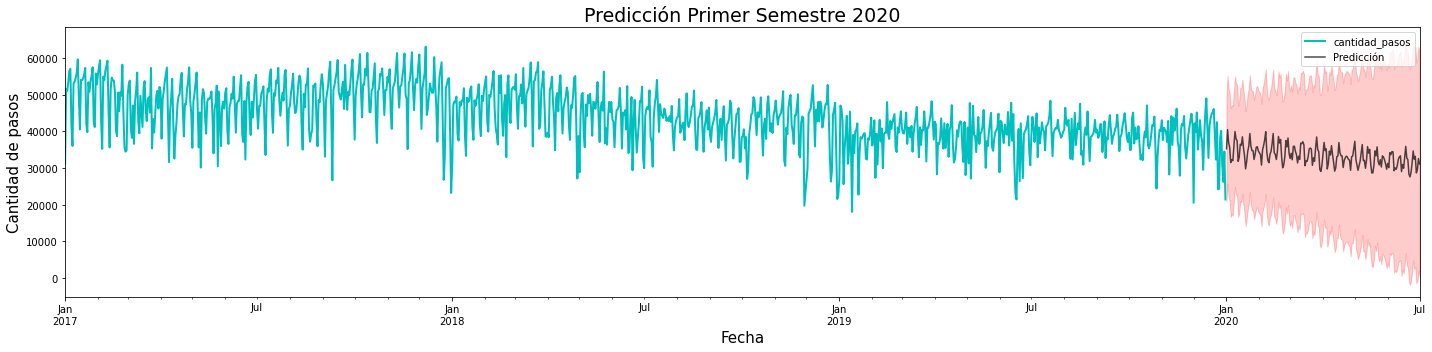

In [106]:
pred = resultado_sarimax.get_forecast(steps=datetime.datetime(2020,7,1))
c_pred = pred.conf_int()
ax = diario['2017':].plot(label='Serie Original',color='c',lw = 2,figsize=(20,5))

pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=0.7, color='Black')

ax.fill_between(c_pred.index,
                c_pred.iloc[:, 0],
                c_pred.iloc[:, 1], color='red', alpha=0.2)
plt.title("Predicción Primer Semestre 2020", fontsize=19)
plt.xlabel('Fecha',size=15)
plt.ylabel('Cantidad de pasos', size=15)
plt.legend()
plt.tight_layout()
plt.show()

A medida que pronosticamos más en el futuro, es natural que tengamos menos confianza en nuestros valores. Esto se refleja en los intervalos de confianza generados por nuestro modelo, que se hacen más grandes a medida que nos adentramos en el futuro.

El modelo es apropiado para predecir el flujo vehicular del año 2020, por lo menos hasta mitad de año con total seguridad.

#### CONCLUSIONES FINALES:

**De todos los modelos realizados, se logra predecir de una forma correcta el último trimestre del año 2019. En lo que respecta al flujo vehicular para el año 2020, no tenemos la certeza de lo que predice el modelo Sarimax a pesar de que el año 2020 nos enfrentamos a una pandemia y el modelo no contemplaba este suceso atípico.**

**Producto de lo acontecido y, debido a las restricciones, la circulación disminuyó de una forma drástica durante diferentes periodos.**

## PARTE C - INVESTIGACIÓN

### Para pensar, investigar y, opcionalmente, implementar

**1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?**

La manera más práctica de agregar esta información es generando variables dummies para cada variable categórica, las cuales pueden agregar información predictiva al modelo. Por otra parte, sería más eficiente considerar que las variables categóricas nos brinden alguna información extra del futuro, como feriados o días festivos. Ambas propuestas mejoran las predicciones. 

**2. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?**

Probablemente se comporten diferentes en algún periodo de tiempo por la diversidad y multiple cantidad de accesos a CABA. Cabe destacar que hoy en día, frente a embotellamientos, accidentes o desvíos, existen aplicaciones de geolocalización que permiten que se agilice la circulación de vehículos y por consiguiente, que aumenten o disminuyan las tendencias de circulación en las distintas estaciones.

**3. ¿Hay algo que te gustaría investigar o probar?**

Tras haber utilizado SARIMAX, pude comprobar que se obtiene una adecuada visualización de la predicción de la cantidad de vehículos que circularían por la Au. Illia durante el primer semestre del 2020. Sin embargo, tras conocer que se tiene mayor error de RMSE, debería trabajar con estos resultados , optimizando aún más el modelo original, algo que llevaré a cabo en el proyecto 04.